In [2]:
%matplotlib inline

import os
# running with non gpu singularity container, so commented out the next line to use CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print "import tensorflow"
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Lambda
from keras.layers import Input, merge, Concatenate, concatenate, Add
from keras.losses import binary_crossentropy
print "import keras"

import numpy as np
#from tqdm import tqdm
import time
import pickle
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print "import matplotlib"

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import binned_statistic_2d

print "import sklearn"

np.random.seed(42)


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


import tensorflow
import keras
import matplotlib

Using TensorFlow backend.



import sklearn


In [3]:
def Minv(cols,ptetaphi=False,nopy2=False):
    """
    Computes M for two objects given the cartesian momentum projections
    if `ptetaphi` is True, then assumes the 8 input columns are cylindrical eptetaphi
    if `nopy2` is True, input is 7 columns with no py2
    """
    if ptetaphi:
        cols = ptetaphi_to_cartesian(cols)
    if nopy2:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]          )**2
        M2 -= (cols[:,3]+cols[:,6])**2
    else:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]+cols[:,6])**2
        M2 -= (cols[:,3]+cols[:,7])**2
    return np.sqrt(M2)

def cartesian_to_ptetaphi(eight_cartesian_cols):
    """
    Takes 8 columns as cartesian e px py pz e px py pz
    and converts to e pt eta phi e pt eta phi
    """
    e1 =  eight_cartesian_cols[:,0]
    e2 =  eight_cartesian_cols[:,4]
    px1 = eight_cartesian_cols[:,1]
    px2 = eight_cartesian_cols[:,5]
    py1 = eight_cartesian_cols[:,2]
    py2 = eight_cartesian_cols[:,6]
    pz1 = eight_cartesian_cols[:,3]
    pz2 = eight_cartesian_cols[:,7]
    p1 = np.sqrt(px1**2+py1**2+pz1**2)
    p2 = np.sqrt(px2**2+py2**2+pz2**2)
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    eta1 = np.arctanh(pz1/p1)
    eta2 = np.arctanh(pz2/p2)
    return np.c_[e1,pt1,eta1,phi1,e2,pt2,eta2,phi2]

def ptetaphi_to_cartesian(eight_eptetaphi_cols):
    """
    Takes 8 columns as e pt eta phi e pt eta phi
    and converts to e px py pz e px py pz
    """
    e1 =  eight_eptetaphi_cols[:,0]
    e2 =  eight_eptetaphi_cols[:,4]
    pt1 =  eight_eptetaphi_cols[:,1]
    pt2 =  eight_eptetaphi_cols[:,5]
    eta1 =  eight_eptetaphi_cols[:,2]
    eta2 =  eight_eptetaphi_cols[:,6]
    phi1 =  eight_eptetaphi_cols[:,3]
    phi2 =  eight_eptetaphi_cols[:,7]
    px1 = np.abs(pt1)*np.cos(phi1)
    px2 = np.abs(pt2)*np.cos(phi2)
    py1 = np.abs(pt1)*np.sin(phi1)
    py2 = np.abs(pt2)*np.sin(phi2)
    pz1 = np.abs(pt1)/np.tan(2.0*np.arctan(np.exp(-1.*eta1)))
    pz2 = np.abs(pt2)/np.tan(2.0*np.arctan(np.exp(-1.*eta2)))
    return np.c_[e1,px1,py1,pz1,e2,px2,py2,pz2]

def get_dphi(px1,py1,px2,py2):
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi 
    return dphi

def get_rotated_pxpy(px1,py1,px2,py2):
    """
    rotates two leptons such that phi2 = 0
    """
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    px1p = pt1*np.cos(phi1-phi2)
    py1p = pt1*np.sin(phi1-phi2)
    px2p = pt2*np.cos(phi2-phi2)
    return px1p,py1p,px2p,np.zeros(len(pt2))
    
def cartesian_zerophi2(coords,ptetaphi=False):
    """
    returns 8-1=7 columns rotating leptons such that phi2 is 0 (and removing it)
    if `ptetaphi` is True, then return eptetaphi instead of epxpypz
    """
    lepcoords_cyl = cartesian_to_ptetaphi(coords)
    phi1 = lepcoords_cyl[:,3]
    phi2 = lepcoords_cyl[:,7]
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi
    lepcoords_cyl[:,3] = dphi
    lepcoords_cyl[:,7] = 0.
    if ptetaphi:
        return np.delete(lepcoords_cyl, [7], axis=1)
    else:
        return np.delete(ptetaphi_to_cartesian(lepcoords_cyl), [6], axis=1)

In [4]:
def invmass_from_8cartesian(x):
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]+x[:,6:7])**2-
                (x[:,3:4]+x[:,7:8])**2
                )
    return invmass

def invmass_from_8cartesian_nopy2(x):
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]         )**2-
                (x[:,3:4]+x[:,6:7])**2
                )
    return invmass

def get_first_N(x,N):
    return x[:,0:N]

def add_invmass_from_8cartesian(x):
    return K.concatenate([x,invmass_from_8cartesian(x)])


def fix_outputs(x):
    """
    Take nominal delphes format of 19 columns and fix some columns
    """
    return K.concatenate([
        # x[:,0:21],
        x[:,0:7], # epxpypz for lep1,lep2 -1 for no py2
        x[:,7:8], # nvtx
        K.sign(x[:,8:10]), # q1 q2
        x[:,10:12], # iso1 iso2
        x[:,12:14], # met, metphi
        x[:,14:19], # jet pts
        ])

def custom_loss(c):
    def loss_func(y_true, y_pred_mll):
        y_true = y_true[:,0]
        y_pred = y_pred_mll[:,0]
        mll_pred = y_pred_mll[:,1]
        
#         mll_loss = K.mean(K.abs(mll_pred - 91.2))

        mll_loss = K.mean((mll_pred - 91.2)**2)

#         pseudomll = K.random_normal_variable(shape=(1,1), mean=91.2, scale=2)
#         mll_loss = K.mean((mll_pred - pseudomll)**2)
        
        return binary_crossentropy(y_true, y_pred) + c*mll_loss
    return loss_func

In [5]:
def make_plots(preds,reals,title="",fname=""):
    nrows, ncols = 5,5
    fig, axs = plt.subplots(nrows,ncols,figsize=(16,13))
    fig.subplots_adjust(wspace=0.1,hspace=0.3)


    info = [
        ["mll",(60,120,50)],
        ["lep1_e",(0,250,50)],
        ["lep1_px",(-100,100,50)],
        ["lep1_py",(-100,100,50)],
        ["lep1_pz",(-200,200,50)],
        ["lep2_e",(0,250,50)],
        ["lep2_px",(-100,100,50)],
        ["lep2_pz",(-200,200,50)],
        ["dphi",(-4,4,50)],
        ["nvtxs",(0,50,350)],
        ["met",(0,150,50)],
        ["metphi",(-6,6,50)],
        ["lep1_charge",(-7,7,30)],
        ["lep2_charge",(-7,7,30)],
        ["lep1_iso",(0,0.2,30)],
        ["lep2_iso",(0,0.2,30)],
        ["genjet_pt1",(0,100,50)],
        ["genjet_pt2",(0,100,50)],
        ["genjet_pt3",(0,100,50)],
        ["genjet_pt4",(0,100,50)],
        ["genjet_pt5",(0,100,50)],

    ]
    for ic,(cname,crange) in enumerate(info):
        if cname == "mll":
            real = reals["mll"]
            pred = Minv(preds,ptetaphi=False,nopy2=True)
        elif cname == "lep1_e": real, pred = reals[cname], preds[:,0]
        elif cname == "lep1_pz": real, pred = reals[cname], preds[:,3]
        elif cname == "lep2_e": real, pred = reals[cname], preds[:,4]
        elif cname == "lep2_pz": real, pred = reals[cname], preds[:,6]
        elif cname == "lep1_px": 
            real = get_rotated_pxpy(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])[0]
            pred = preds[:,1]
        elif cname == "lep1_py":
            real = get_rotated_pxpy(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])[1]
            pred = preds[:,2]
        elif cname == "lep2_px":
            real = get_rotated_pxpy(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])[2]
            pred = preds[:,5]
        elif cname == "dphi":
            real = get_dphi(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], reals["lep2_py"])
            pred = get_dphi(preds[:,1], preds[:,2], preds[:,5], np.zeros(len(preds)))
        elif cname == "nvtxs": real, pred = reals[cname], np.round(preds[:,7])
        elif cname == "lep1_charge": real, pred = reals[cname], preds[:,8]
        elif cname == "lep2_charge": real, pred = reals[cname], preds[:,9]
        elif cname == "lep1_iso": real, pred = reals[cname], preds[:,10]
        elif cname == "lep2_iso": real, pred = reals[cname], preds[:,11]
        elif cname == "met": real, pred = reals[cname], preds[:,12]
        elif cname == "metphi": real, pred = reals[cname], preds[:,13]
        elif cname == "genjet_pt1": real, pred = reals[cname], preds[:,14]
        elif cname == "genjet_pt2": real, pred = reals[cname], preds[:,15]
        elif cname == "genjet_pt3": real, pred = reals[cname], preds[:,16]
        elif cname == "genjet_pt4": real, pred = reals[cname], preds[:,17]
        elif cname == "genjet_pt5": real, pred = reals[cname], preds[:,18]
        idx = ic // ncols, ic % ncols
        bins_real = axs[idx].hist(real, range=crange[:2],bins=crange[-1], histtype="step", lw=2,density=True)
        bins_pred = axs[idx].hist(pred, range=crange[:2],bins=crange[-1], histtype="step", lw=2,density=True)
        axs[idx].set_xlabel("{}".format(cname))
        axs[idx].get_yaxis().set_visible(False)
    #     axs[idx].set_yscale("log", nonposy='clip')
    _ = axs[0,0].legend(["True","Pred"], loc='upper right')
    _ = axs[0,0].set_title(title)
    plt.tight_layout()
    if fname:
        fig.savefig(fname)


In [6]:
class GAN():
    def __init__(self, **kwargs):

        self.args = dict(kwargs)

        self.tag = kwargs["tag"]
        self.input_file = str(kwargs["input_file"])
        self.noise_shape = (int(kwargs["noise_size"]),)
        self.output_shape = (int(kwargs["output_size"]),)
        self.noise_type = int(kwargs["noise_type"])
        self.ntest_samples = int(kwargs["ntest_samples"])
        self.nepochs_dump_pred_metrics = int(kwargs["nepochs_dump_pred_metrics"])
        self.nepochs_dump_models = int(kwargs["nepochs_dump_models"])
        self.nepochs_dump_plots = int(kwargs["nepochs_dump_plots"])
        self.nepochs_max = int(kwargs["nepochs_max"])
        self.batch_size = int(kwargs["batch_size"])
        self.do_concatenate_disc = kwargs["do_concatenate_disc"]
        self.do_concatenate_gen = kwargs["do_concatenate_gen"]
        self.do_batch_normalization_disc = kwargs["do_batch_normalization_disc"]
        self.do_batch_normalization_gen = kwargs["do_batch_normalization_gen"]
        self.do_soft_labels = kwargs["do_soft_labels"]
        self.do_noisy_labels = kwargs["do_noisy_labels"]
        self.do_tanh_gen = kwargs["do_tanh_gen"]
        self.nepochs_decay_noisy_labels = int(kwargs["nepochs_decay_noisy_labels"])
        self.use_ptetaphi_additionally = kwargs["use_ptetaphi_additionally"]
        self.optimizer_gen = kwargs["optimizer_gen"]
        self.optimizer_disc = kwargs["optimizer_disc"]
        self.depth_disc = kwargs["depth_disc"]
        self.width_disc = kwargs["width_disc"]
        self.depth_gen = kwargs["depth_gen"]
        self.width_gen = kwargs["width_gen"]
        self.beefy_generator = kwargs["beefy_generator"]
        self.beefy_discriminator = kwargs["beefy_discriminator"]
        self.add_invmass_disc = kwargs["add_invmass_disc"]
        self.fix_delphes_outputs = kwargs["fix_delphes_outputs"]
        self.use_delphes = kwargs["use_delphes"]
        self.use_mll_loss = kwargs["use_mll_loss"]
        self.loss_mll_weight = kwargs["loss_mll_weight"]
        self.do_skip_connection = kwargs["do_skip_connection"]
        self.terminate_early = kwargs["terminate_early"]
        if self.use_ptetaphi_additionally: self.output_shape = (self.output_shape[0]+8,)

        os.system("mkdir -p progress/{}/".format(self.tag))
        os.system("cp gan.py progress/{}/".format(self.tag))

        self.scaler_type = kwargs["scaler_type"]
        self.scaler = None
        if self.scaler_type.lower() == "minmax":
            self.scaler = MinMaxScaler(feature_range=(-1.,1.))
        elif self.scaler_type.lower() == "robust":
            self.scaler = RobustScaler()
        elif self.scaler_type.lower() == "standard":
            self.scaler = StandardScaler()

        self.data = None
        self.data_ref = None
        self.d_epochinfo = {}
        self.X_train = None

        # optimizer = Adam(0.0002, 0.5)
        optimizer_d = self.optimizer_disc
        # optimizer_d = "sgd"
        optimizer_g = self.optimizer_gen
        # optimizer_g = "adam"

        # Build and compile the discriminator
        if self.use_mll_loss:
            loss = custom_loss(c=self.loss_mll_weight)
        else:
            loss = "binary_crossentropy"
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=loss,
            optimizer=optimizer_d,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=loss, optimizer=optimizer_g)

        # The generator takes noise as input and generated imgs
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=loss, optimizer=optimizer_g)


In [7]:
class GAN(GAN):
    
    def build_generator(self):

        inputs = Input(shape=self.noise_shape)

        ## Head
        x = Dense(64)(inputs)
        if self.do_batch_normalization_gen:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        if self.do_concatenate_gen:
            x = Lambda(lambda x: K.concatenate([x*x,x]))(x)
            x = LeakyReLU(alpha=0.2)(x)

        ## Main Body
        if self.depth_gen > 0 and self.width_gen > 0:
            for level in xrange(0,self.depth_gen):
                x = Dense(width_gen/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_generator:
            for size in [128,256,512,256,128]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
        else:
            for size in [128,128,128,64,32]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
 
        ## Tail
        x = Dense(self.output_shape[0])(x)
        
#         if False:
        if self.do_skip_connection:
            # get the non-noise part of the input, and add it to the tail
            #num_real_bytes = 
            z = Lambda(lambda y,w=self.output_shape[0]: y[:,0:w], output_shape=self.output_shape)(inputs)
#             print y
            x = Add()([x,z])
#             print x
            
        if self.do_tanh_gen:
            x = Activation("tanh")(x)
        elif self.fix_delphes_outputs:
            x = Lambda(fix_outputs,
                input_shape=self.output_shape,
                output_shape=self.output_shape
                )(x)
            
#         model = Model(inputs=inputs, outputs=concatenate([out,mll]))
        model = Model(inputs=inputs, outputs=[x])
        
        print "Generator params: {}".format(model.count_params())
#         model.summary()
        
        return model

In [8]:
class GAN(GAN):
    
    def build_discriminator(self):

        inputs = Input(self.output_shape)
        mll = Lambda(invmass_from_8cartesian_nopy2)(inputs)
        x = Dense(128)(inputs)
        if self.do_batch_normalization_disc:
            x = BatchNormalization()(x)
        if self.do_concatenate_disc:
            x = Lambda(lambda x: K.concatenate([x*x,x]))(x)
            x = LeakyReLU(alpha=0.2)(x)

        ## Main Body
        if self.depth_disc > 0 and self.width_disc > 0:
            for level in xrange(0,self.depth_disc):
                x = Dense(self.width_disc/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_generator:
            for size in [128,256,256,128,64,32,16,8]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)

        else:
            for size in [128]*5 + [64,32,16,8]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)

        ## Tail
        out = Dense(1,activation='sigmoid')(x)
        
        if self.use_mll_loss:
            model = Model(inputs=inputs, outputs=concatenate([out,mll]))
        else:
            model = Model(inputs=inputs, outputs=out)
#         print model.output_shape
#         model.summary()
        print "Discriminator params: {}".format(model.count_params())
        
        return model
        


In [9]:
class GAN(GAN):
    
    def load_data(self):
        if self.data is not None: return
        
        if self.use_delphes:
            self.data = np.load(self.input_file)
        else:
            self.data = np.load(self.input_file)

In [10]:
class GAN(GAN):

    def get_noise(self, amount=1024):
        # nominal
        if self.noise_type == 1:
            noise_half = np.random.normal(0, 1, (amount//2, self.noise_shape[0]))
            noise_full = np.random.normal(0, 1, (amount, self.noise_shape[0]))

        elif self.noise_type == 2: # random soup, 4,2,2 have to be modified to sum to noise_shape[0]
            ngaus = self.noise_shape[0] // 2
            nflat = (self.noise_shape[0] - ngaus) // 2
            nexpo = self.noise_shape[0] - nflat - ngaus
            noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
            noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
            noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
            noise = np.c_[ noise_gaus,noise_flat,noise_expo ]
            noise_half = noise[:amount//2]
            noise_full = noise[-amount:]
            
        elif self.noise_type == 3: # truth conditioned
            
#             noise_half = np.c_[ 
#                     self.X_train[np.random.randint(0, self.X_train.shape[0], amount//2)], 
#                     np.random.normal(0, 1, (amount//2,self.noise_shape[0]-self.X_train.shape[1]))
#                     ]
#             noise_full = np.c_[ 
#                     self.X_train[np.random.randint(0, self.X_train.shape[0], amount)], 
#                     np.random.normal(0, 1, (amount,self.noise_shape[0]-self.X_train.shape[1]))
#                     ]
            
            npurenoise = self.noise_shape[0]-self.X_train.shape[1]
            ngaus = npurenoise // 2
            nflat = (npurenoise - ngaus) // 2
            nexpo = npurenoise - nflat - ngaus
            noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
            noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
            noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
            truenoise = self.X_train[np.random.randint(0, self.X_train.shape[0], amount//2+amount)]
            noise = np.c_[ truenoise,noise_gaus,noise_flat,noise_expo ]
            noise_half = noise[:amount//2]
            noise_full = noise[-amount:]

        return noise_half, noise_full



In [11]:
class GAN(GAN):
            
    def train(self):

        self.load_data()
        
        if self.use_delphes:
            lepcoords = np.c_[
                self.data["lep1_e"],
                self.data["lep1_px"],
                self.data["lep1_py"],
                self.data["lep1_pz"],
                self.data["lep2_e"],
                self.data["lep2_px"],
                self.data["lep2_py"],
                self.data["lep2_pz"],
            ]
            lepcoords_dphi = cartesian_zerophi2(lepcoords)
            
            nvtx_smeared = np.round(np.random.normal(self.data["nvtxs"],0.5))
            self.X_train = np.c_[
                lepcoords_dphi, # 7 columns
                nvtx_smeared, # 1 column
                self.data["lep1_charge"], self.data["lep2_charge"],
                self.data["lep1_iso"], self.data["lep2_iso"],
                self.data["met"], self.data["metphi"],
                self.data["genjet_pt1"],
                self.data["genjet_pt2"],
                self.data["genjet_pt3"],
                self.data["genjet_pt4"],
                self.data["genjet_pt5"],
            ].astype(np.float32)
        else:
            self.X_train = self.data[:,range(1,1+8)]
            if self.use_ptetaphi_additionally:
                self.X_train = np.c_[self.X_train, cartesian_to_ptetaphi(self.X_train)]

        # # NOTE. StandardScaler should be fit on training set
        # # and applied the same to train and test, otherwise we
        # # introduce a bias
        if self.scaler:
            self.scaler.fit(self.X_train)
            self.X_train = self.scaler.transform(self.X_train).astype(np.float32)
            pickle.dump(self.scaler, open("progress/{}/scaler.pkl".format(self.tag),'w'))

        # make an alias to save typing
        X_train = self.X_train
        
        half_batch = int(self.batch_size / 2)

        prev_gen_loss = -1
        prev_disc_loss = -1
        n_loss_same_gen = 0  # number of epochs for which generator loss has remained ~same (within 0.01%)
        n_loss_same_disc = 0  # number of epochs for which discriminator loss has remained ~same (within 0.01%)
        old_info = -1, -1
        for epoch in range(self.nepochs_max):

            if self.terminate_early:
                if n_loss_same_gen > 1000 or n_loss_same_disc > 1000:
                    print "BREAKING because disc/gen loss has remained the same for {}/{} epochs!".format(n_loss_same_disc,n_loss_same_gen)
                    break

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            
            noise_half, noise_full = self.get_noise(self.batch_size)
            
            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise_half)

            # Train the discriminator
            ones = np.ones((half_batch, 1))
            zeros = np.zeros((half_batch, 1))

            if self.do_soft_labels:
                ones *= 0.9

            if self.do_noisy_labels:
                frac = 0.3*np.exp(-epoch/self.nepochs_decay_noisy_labels)
                if frac > 0.005:
                    ones[np.random.randint(0, len(ones), int(frac*len(ones)))] = 0
                    zeros[np.random.randint(0, len(zeros), int(frac*len(zeros)))] = 1

            d_loss_real = self.discriminator.train_on_batch(imgs, ones)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, zeros)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * self.batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise_full, valid_y)

            if (g_loss - prev_gen_loss) < 0.0001: n_loss_same_gen += 1
            else: n_loss_same_gen = 0
            prev_gen_loss = g_loss

            if (d_loss[0] - prev_disc_loss) < 0.0001: n_loss_same_disc += 1
            else: n_loss_same_disc = 0
            prev_disc_loss = d_loss[0]

            # Plot the progress
#             print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            sys.stdout.write("\r{} [D loss: {}, acc.: {:.2f}%] [G loss: {}] [mll={:.3f}+-{:.3f}]".format(epoch, d_loss[0], 100.0*d_loss[1], g_loss, old_info[0], old_info[1]))

            if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
            
                _, noise_test = self.get_noise(self.ntest_samples)
            
                sys.stdout.write("\n") # break up the stream of text

                gen_imgs = self.generator.predict(noise_test)

                if self.scaler:
                    gen_imgs = self.scaler.inverse_transform(gen_imgs)

                masses = Minv(gen_imgs,nopy2=True)
                masses = masses[np.isfinite(masses)]
                old_info = masses.mean(), masses.std()

                if "epoch" not in self.d_epochinfo:
                    self.d_epochinfo["epoch"] = []
                    self.d_epochinfo["d_acc"] = []
                    self.d_epochinfo["d_loss"] = []
                    self.d_epochinfo["g_loss"] = []
                    self.d_epochinfo["mass_mu"] = []
                    self.d_epochinfo["mass_sig"] = []
                    self.d_epochinfo["time"] = []
                    self.d_epochinfo["args"] = self.args
                else:
                    self.d_epochinfo["epoch"].append(epoch)
                    self.d_epochinfo["d_acc"].append(100*d_loss[1])
                    self.d_epochinfo["d_loss"].append(d_loss[0])
                    self.d_epochinfo["g_loss"].append(g_loss)
                    self.d_epochinfo["mass_mu"].append(masses.mean())
                    self.d_epochinfo["mass_sig"].append(masses.std())
                    self.d_epochinfo["time"].append(time.time())

                pickle.dump(self.d_epochinfo, open("progress/{}/history.pkl".format(self.tag),'w'))

            if epoch % self.nepochs_dump_plots == 0 and epoch > 0:
                _, noise = self.get_noise(self.ntest_samples)
                preds = gan.generator.predict(noise)
                reals = self.data[:15000]
                _ = make_plots(preds,reals,title="{}: epoch {}".format(self.tag,epoch),
                               fname="progress/{}/plots_{:06d}.png".format(self.tag,epoch))
            
            if epoch % self.nepochs_dump_models == 0 and epoch > 0:
                self.discriminator.save("progress/{}/disc_{}.weights".format(self.tag,epoch))
                self.generator.save("progress/{}/gen_{}.weights".format(self.tag,epoch))

In [12]:
# defaults
params = {
        "input_file": "data_xyz.npy",
        "output_size": 8,
        "noise_size": 8,
        "noise_type": 1,
        "ntest_samples": 10000,
        "nepochs_dump_pred_metrics": 250,
        "nepochs_dump_plots": 500,
        "nepochs_dump_models": 5000,
        "nepochs_max": 25001,
        "batch_size": 200,
        "do_concatenate_disc": False,
        "do_concatenate_gen": False,
        "do_batch_normalization_disc": False,
        "do_batch_normalization_gen": False,
        "do_soft_labels": False,
        "do_noisy_labels": False,
        "do_tanh_gen": False,
        "nepochs_decay_noisy_labels": 3000,
        "use_ptetaphi_additionally": False,
        "scaler_type": "",
        "optimizer_disc": "adadelta",
        "optimizer_gen": "adadelta",
        "beefy_generator": False,
        "beefy_discriminator": False,
        "depth_gen": 0,
        "width_gen": 0,
        "depth_disc": 0,
        "width_disc": 0,
        "add_invmass_disc": False,
        "fix_delphes_outputs": False,
        "use_delphes": False,
        "use_mll_loss": False,
        "loss_mll_weight": 0.0001,
        "do_skip_connection": False,
        "terminate_early": True,
        }

# for delphes:
params.update({
    "use_delphes": True,
    "fix_delphes_outputs": True,
    "do_soft_labels": True,
    "do_noisy_labels": True,
    "nepochs_decay_noisy_labels": 2000,
    "input_file": "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa",
    "output_size": 19,
})
params.update({
    "noise_type": 3,
    "noise_size": 19+12, # 19 for the true events and 8 more for noise
#     "use_mll_loss": True,
#     "loss_mll_weight": 0.001,
    "nepochs_max": 25001,
    "batch_size": 512,
    "do_skip_connection": True,
    "terminate_early": False,
    "nepochs_dump_models": 500, # can't dump models? FIXME
    "beefy_generator": True,
    "beefy_discriminator": True,
})
print params
    
# change tag for provenance
# params["tag"] = "v1_512_bgbd_nomll"
params["tag"] = "v1_512_skipconn_bgbd_nomll"

gan = GAN(**params)

{'width_disc': 0, 'ntest_samples': 10000, 'optimizer_disc': 'adadelta', 'output_size': 19, 'terminate_early': False, 'do_batch_normalization_disc': False, 'use_delphes': True, 'nepochs_dump_plots': 500, 'use_ptetaphi_additionally': False, 'do_noisy_labels': True, 'nepochs_dump_pred_metrics': 250, 'do_batch_normalization_gen': False, 'add_invmass_disc': False, 'width_gen': 0, 'fix_delphes_outputs': True, 'nepochs_dump_models': 500, 'input_file': '/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/data_Nov10.npa', 'noise_type': 3, 'scaler_type': '', 'batch_size': 512, 'do_concatenate_disc': False, 'do_soft_labels': True, 'depth_gen': 0, 'noise_size': 31, 'loss_mll_weight': 0.0001, 'nepochs_max': 25001, 'beefy_discriminator': True, 'depth_disc': 0, 'do_tanh_gen': False, 'do_skip_connection': True, 'use_mll_loss': False, 'beefy_generator': True, 'nepochs_decay_noisy_labels': 2000, 'optimizer_gen': 'adadelta', 'do_concatenate_gen': False}
Discriminator params: 161793
Generator params: 341651


/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


250 [D loss: 0.69159245491, acc.: 49.61%] [G loss: 0.744520902634] [mll=-1.000+--1.000]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


500 [D loss: 0.689890861511, acc.: 50.20%] [G loss: 0.771826207638] [mll=91.609+-27.110]


/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


750 [D loss: 0.689871013165, acc.: 50.20%] [G loss: 0.782422780991] [mll=85.672+-19.255]
1000 [D loss: 0.690517187119, acc.: 49.80%] [G loss: 0.785200238228] [mll=90.345+-17.825]
1250 [D loss: 0.69052028656, acc.: 49.80%] [G loss: 0.786733865738] [mll=95.965+-16.646]]
1500 [D loss: 0.690863966942, acc.: 49.61%] [G loss: 0.787285327911] [mll=99.609+-19.656]
1750 [D loss: 0.688851892948, acc.: 50.78%] [G loss: 0.787744820118] [mll=101.110+-19.962]
2000 [D loss: 0.689923763275, acc.: 50.20%] [G loss: 0.787806868553] [mll=98.985+-19.438]
2250 [D loss: 0.690057992935, acc.: 50.00%] [G loss: 0.793741464615] [mll=98.673+-19.389]
2500 [D loss: 0.690392076969, acc.: 49.80%] [G loss: 0.794561326504] [mll=97.362+-17.547]
2750 [D loss: 0.690022468567, acc.: 50.00%] [G loss: 0.794783115387] [mll=97.729+-16.779]
3000 [D loss: 0.69000005722, acc.: 50.00%] [G loss: 0.794865846634] [mll=97.050+-15.477]]
3250 [D loss: 0.690348625183, acc.: 49.80%] [G loss: 0.795009732246] [mll=96.153+-14.915]
3500 [D lo

KeyboardInterrupt: 

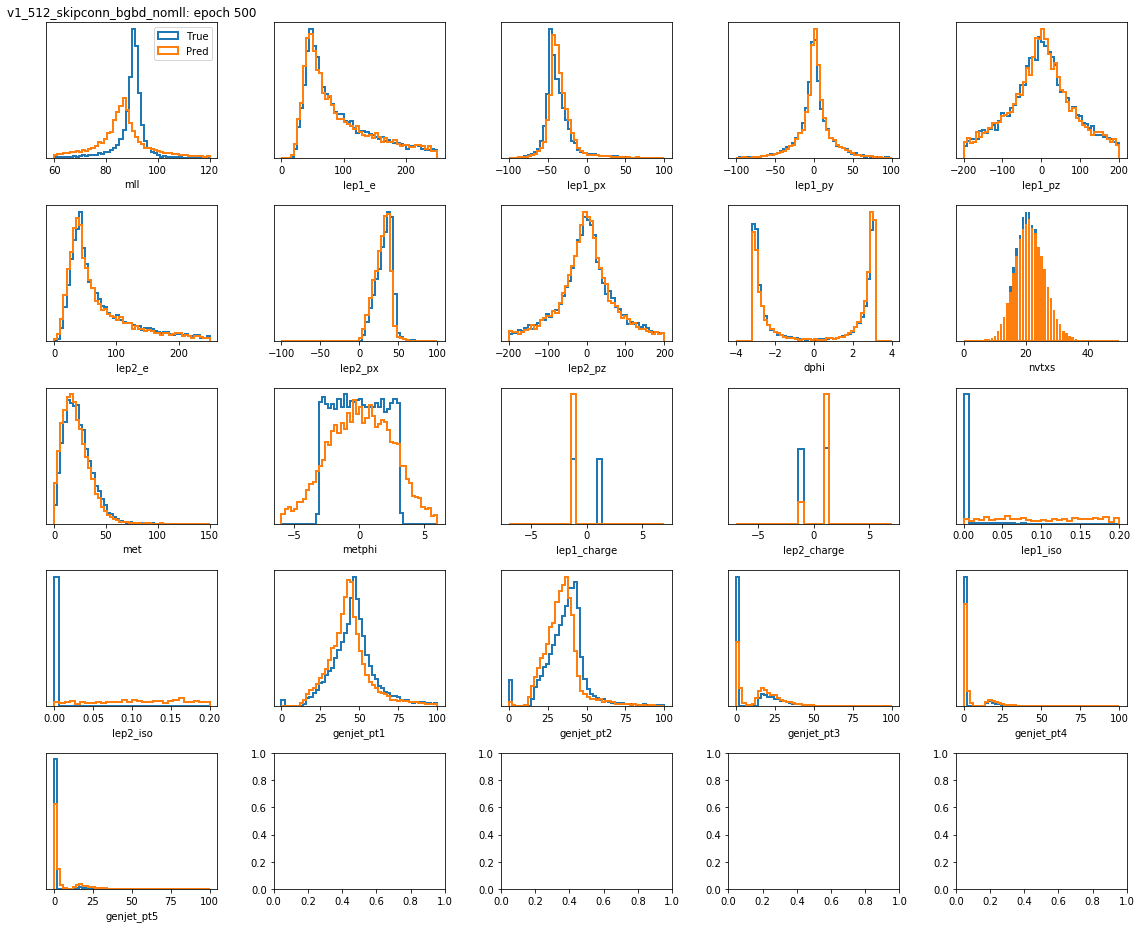

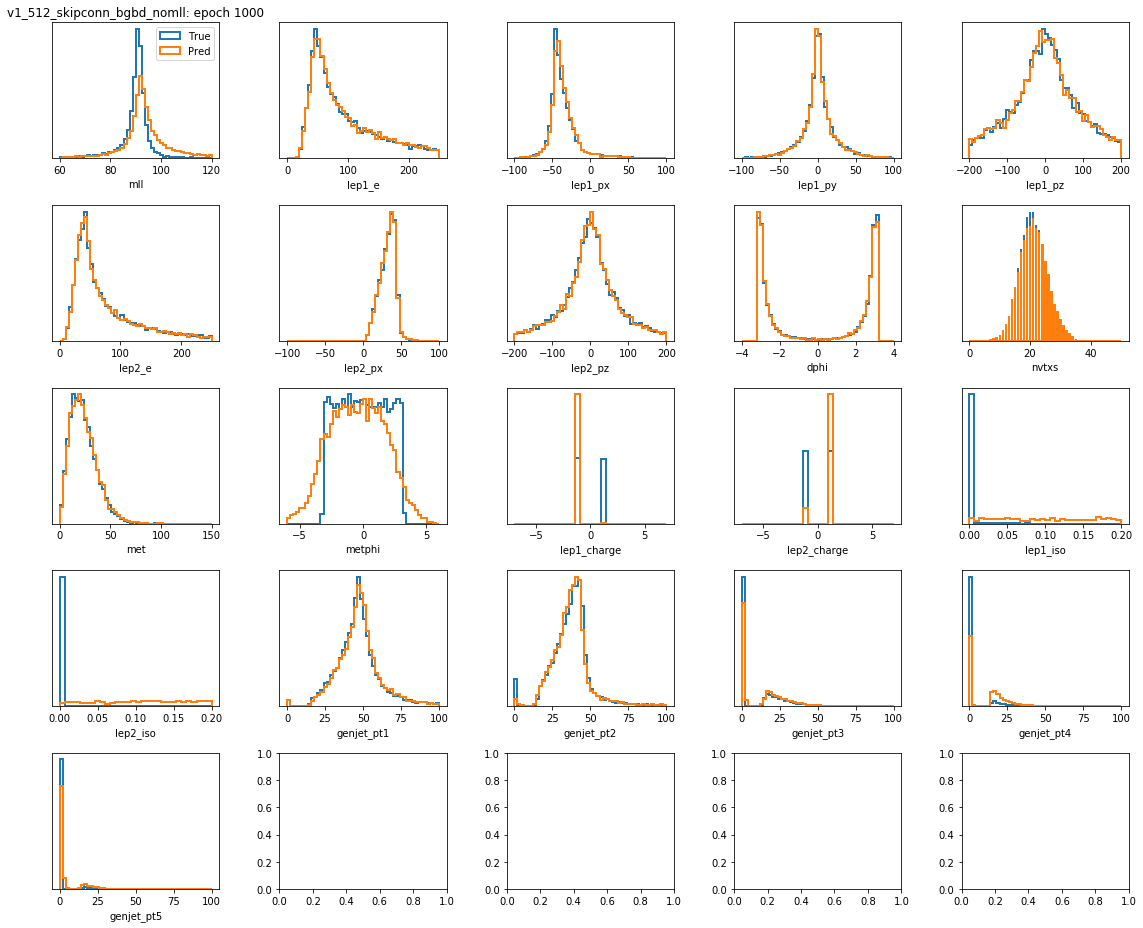

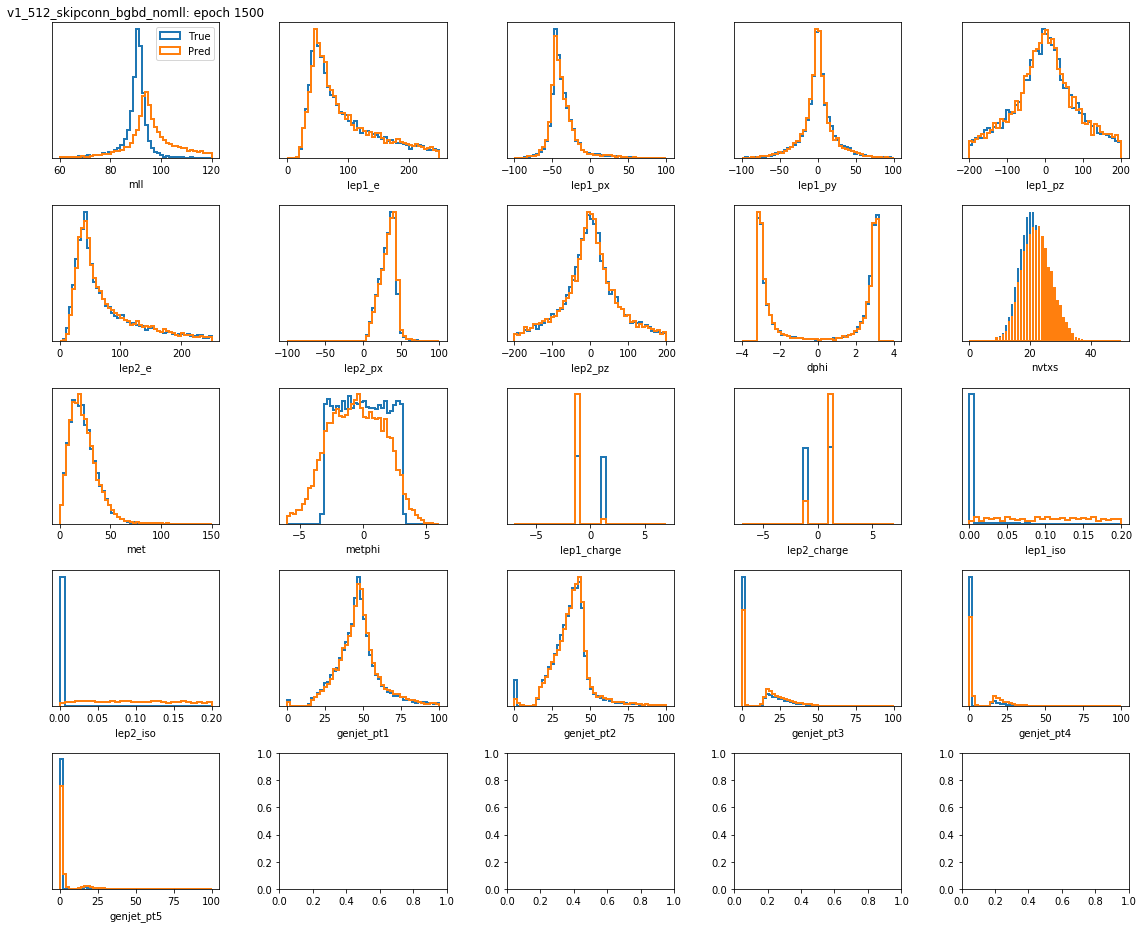

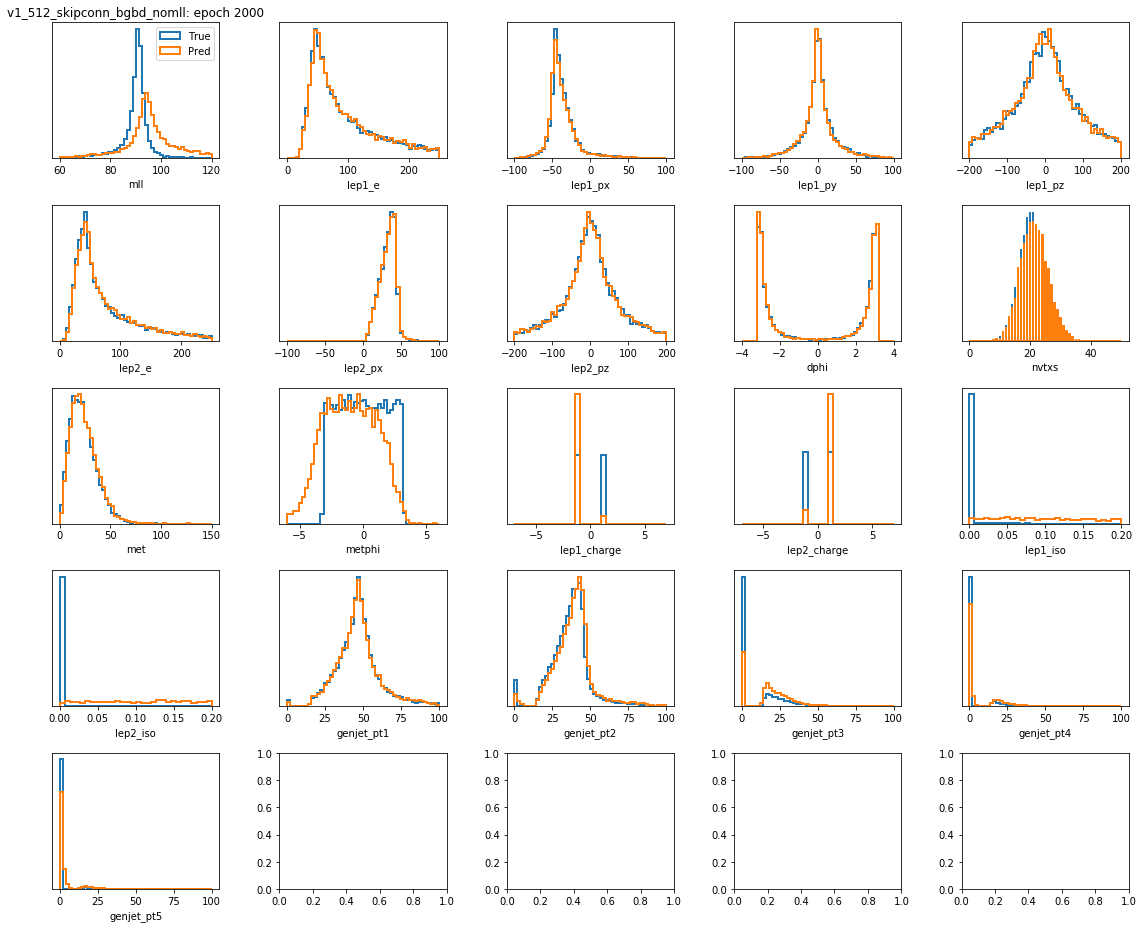

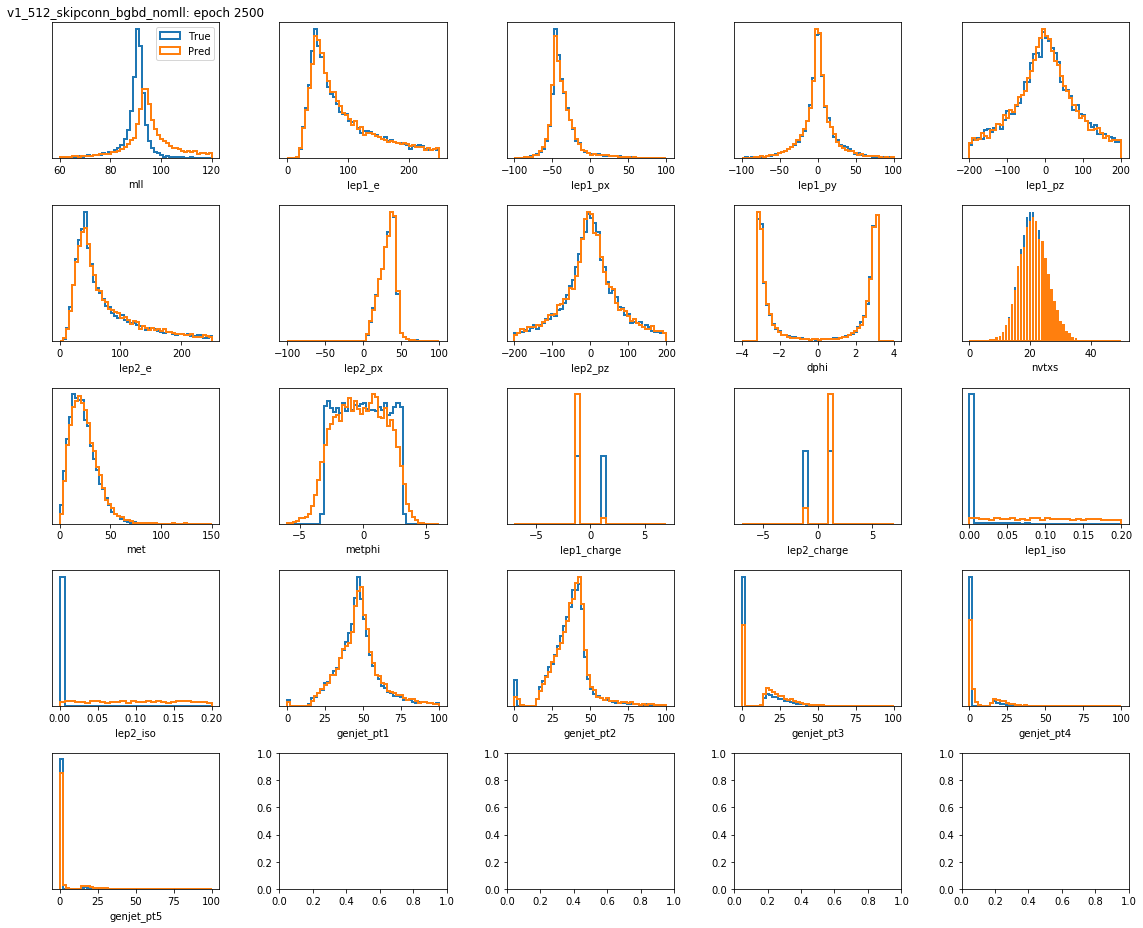

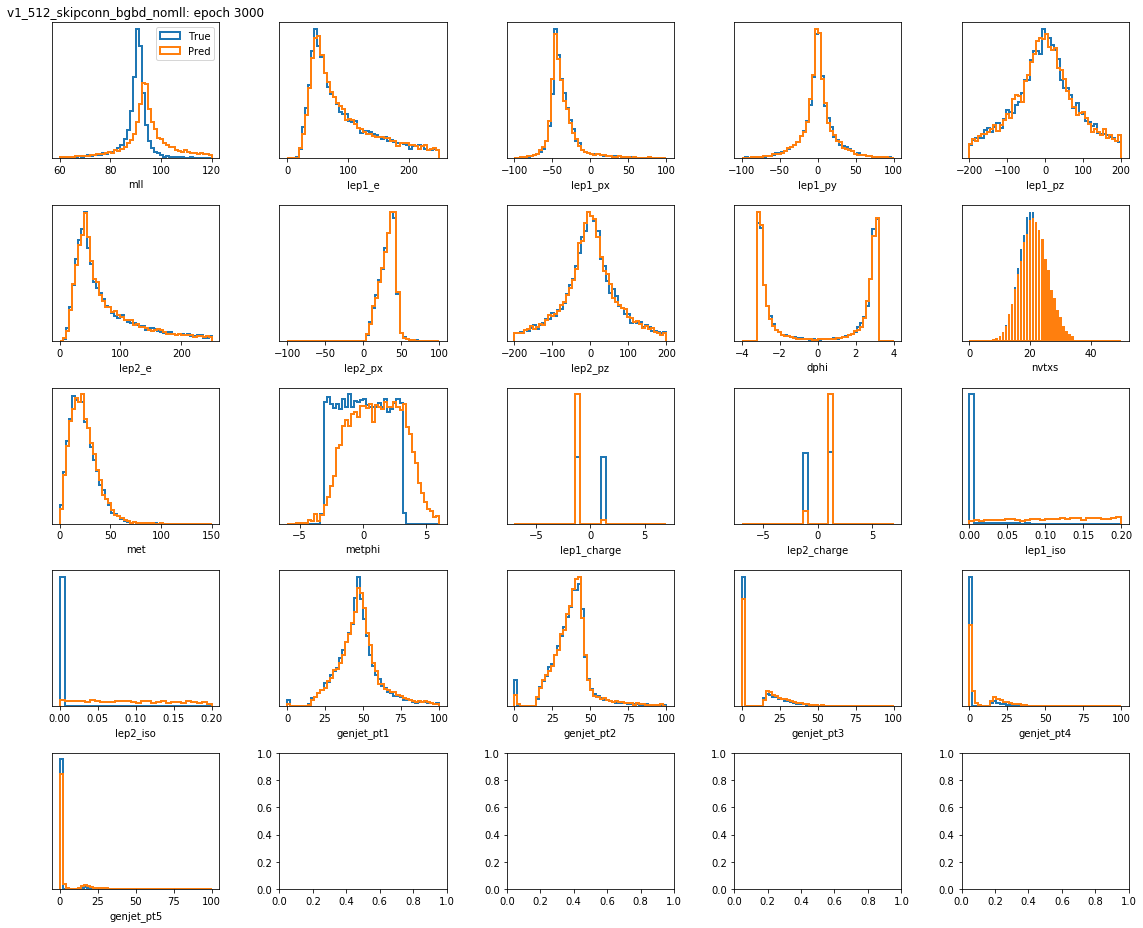

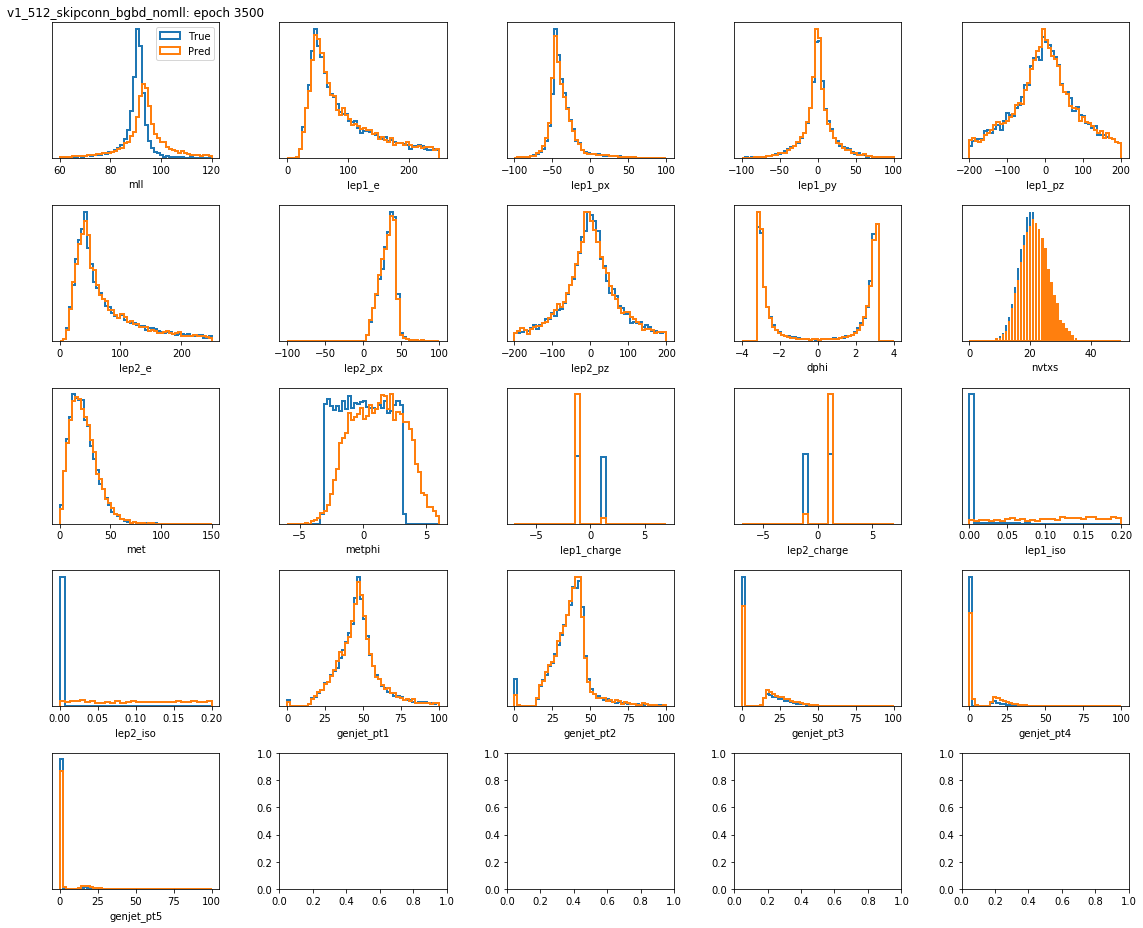

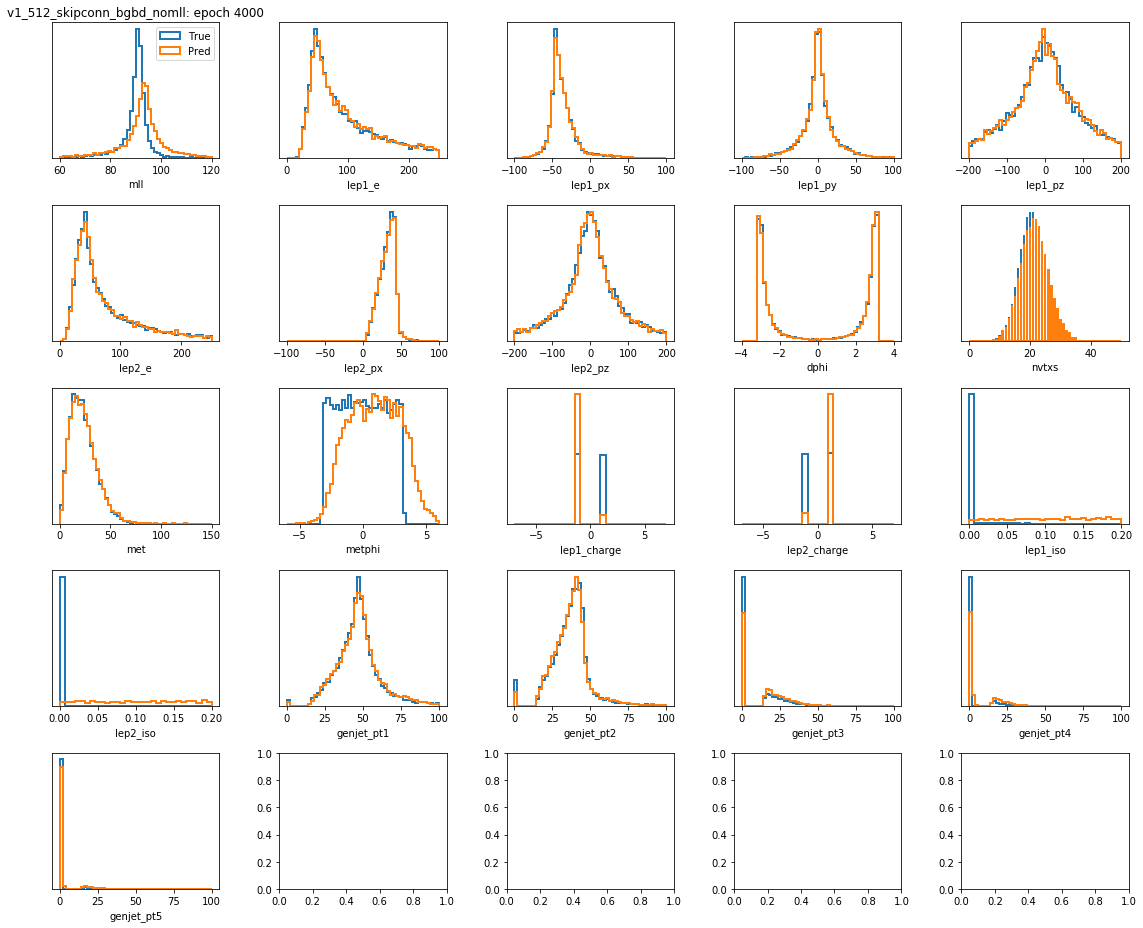

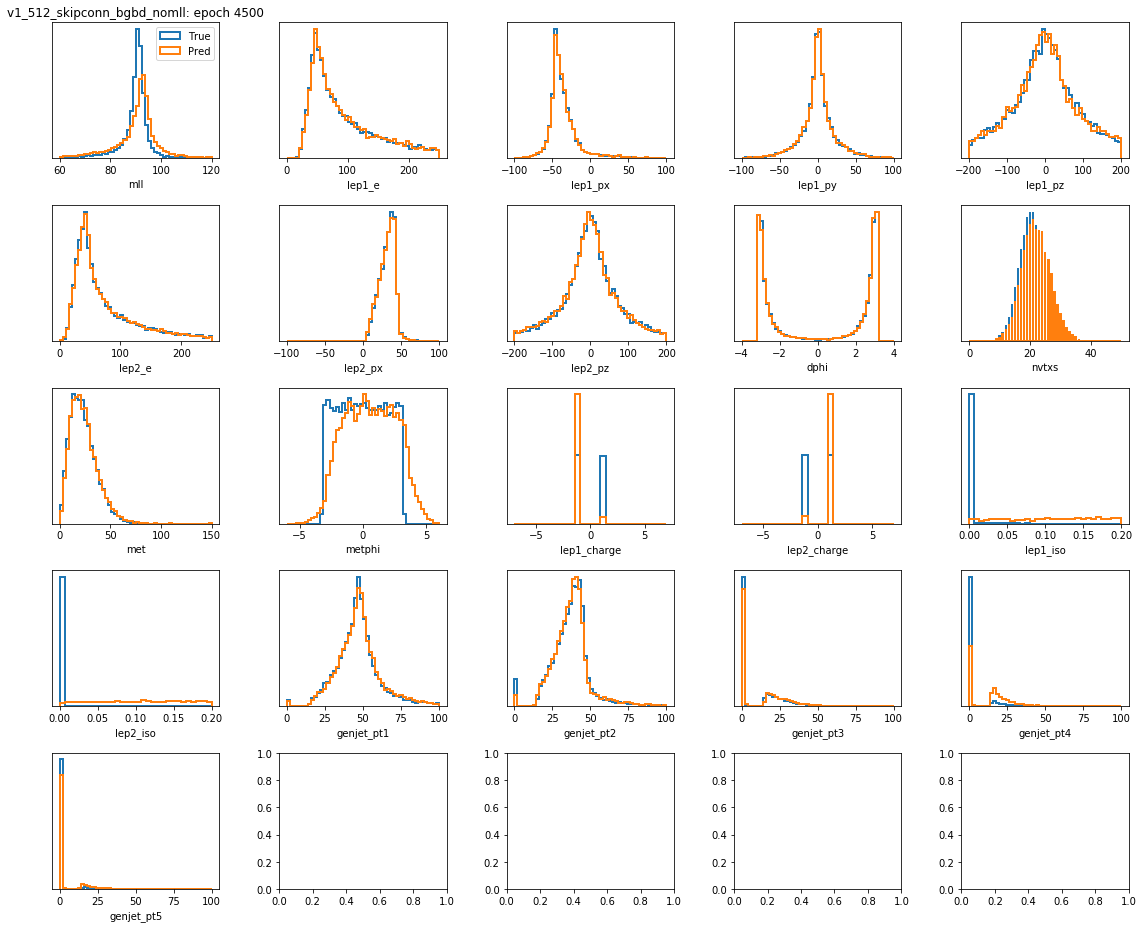

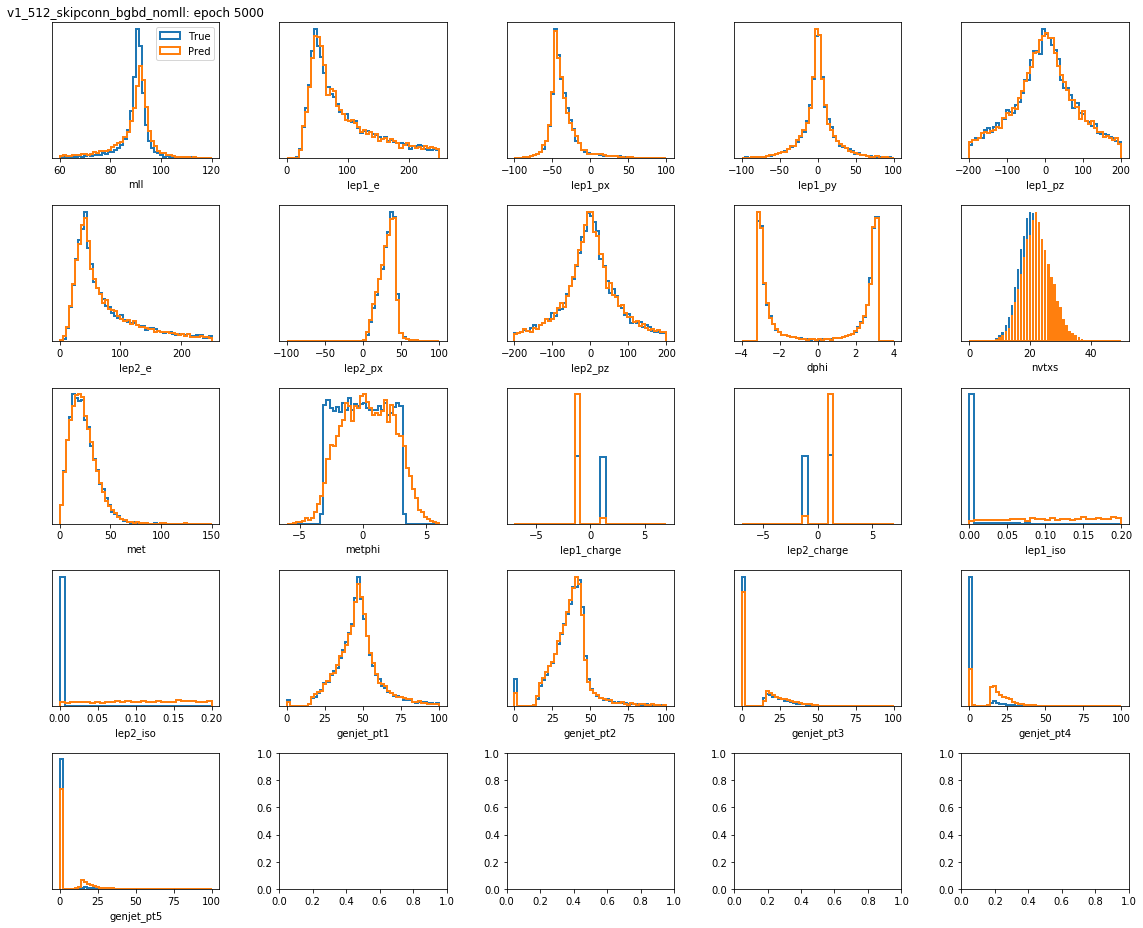

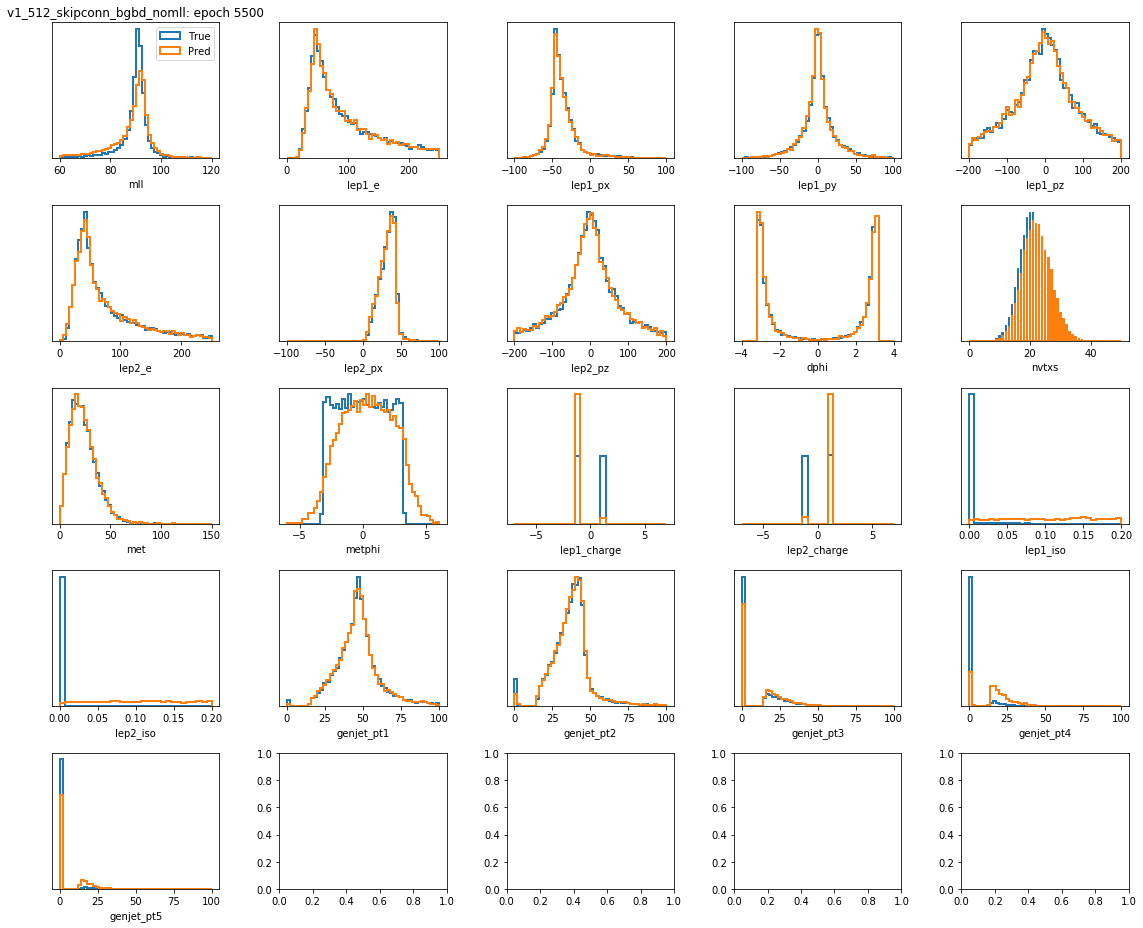

In [13]:
gan.train()

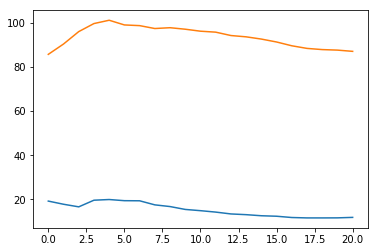

In [14]:
# plot masses
plt.plot(gan.d_epochinfo["mass_sig"])
plt.plot(gan.d_epochinfo["mass_mu"])

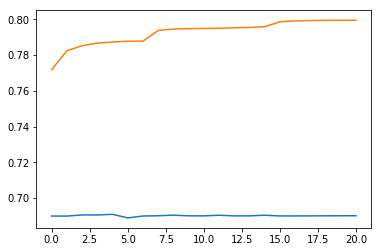

In [15]:
# plot losses
plt.plot(gan.d_epochinfo["d_loss"])
plt.plot(gan.d_epochinfo["g_loss"])

[ 7.34940131e-01 -2.36606832e-01  1.05362697e-01 -1.29630230e+00
 -2.45768465e-01 -7.12002511e-01 -1.03756607e+00  1.23279118e+00
 -9.21840000e-01  9.04000000e-01  5.56687523e-01 -1.04525432e-01
  1.06142527e-01  3.96888592e-01 -7.22693670e-04  2.02383937e-01
  1.09823133e-01 -8.11995347e-01 -8.13516007e-01]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


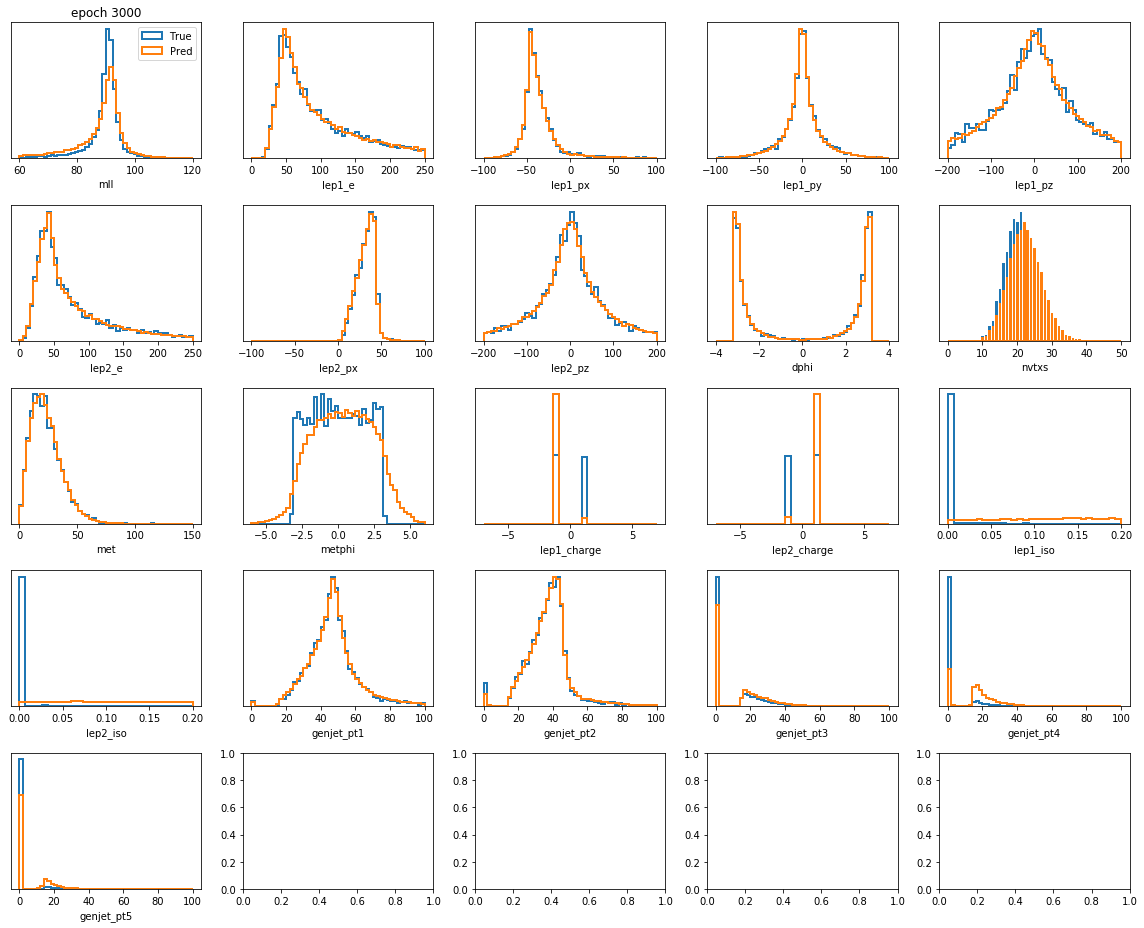

In [16]:
# get noise, predict from it, and plot stuff. easy.
_, noise = gan.get_noise(50000)
# print noise
# print noise.shape
# print noise
preds = gan.generator.predict(noise)
print (preds-noise[:,0:19]).mean(axis=0)
# make_plots(noise,gan.data[:5000],title="epoch {}".format(3000))
make_plots(preds,gan.data[:5000],title="epoch {}".format(3000))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


89.55537341978633 7.71629416905781
87.15146 11.858054
[-1.14323440e+00  6.13466789e-02 -1.03191963e+00 -1.41171852e+00
 -7.30254165e-01  3.21537384e+01  8.99095764e-01 -1.16152227e+00
  5.19463784e+00 -1.47524381e+00 -4.66756618e-01  2.77876483e+01
  4.01289666e+00 -6.71585849e-01 -6.05695744e-01 -2.43245323e+00
 -6.27859052e-03 -1.76665097e-01 -1.74164544e+00 -2.18181502e+00
  1.36783513e+00 -9.57858450e-01  3.56930509e+01  1.13054424e+01
  1.22614531e+01 -4.57171360e-01 -8.33550304e+00  8.55545255e+00
 -1.63932741e+00 -1.28177759e+00 -4.22027568e-01  5.71310554e+00
  3.32704682e+00 -5.27506974e-01 -1.73680283e+00 -6.95670119e-01
 -1.02563854e+00 -1.50724765e+00 -1.19058522e+00 -1.73201080e+00
 -6.60751653e-01 -1.16739886e+00 -7.81875603e-01 -4.96796185e-02
  5.78762809e+00 -8.60328842e-01 -1.50540573e+00  1.27594355e+00
 -2.97011023e-01  1.04563538e+01 -2.82350238e+00 -8.87274333e-01
 -1.31944300e+00  6.13818196e+00  3.63813909e+01  1.41671792e+01
 -5.20790115e-01 -6.50042545e-01 -2.

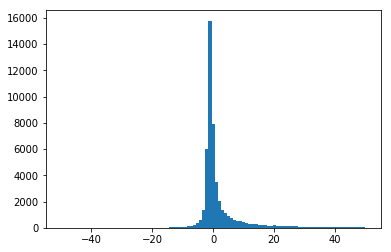

In [17]:
mfake = Minv(preds,nopy2=True)
mreal = Minv(noise[:,0:19],nopy2=True)
mreal = mreal[np.isfinite(mfake)]
mfake = mfake[np.isfinite(mfake)]
print mreal.mean(), mreal.std()
print mfake.mean(), mfake.std()
print (mreal-mfake)[:100]
_ = plt.hist(mreal-mfake,bins=np.linspace(-50,50,100))

# _ = plt.hist((preds-noise[:,0:19])[:,18],bins=30)

In [ ]:
bins = np.linspace(0,100,50)
_ = plt.hist(gan.data["met"][gan.data["nvtxs"] < 18],bins=bins,histtype="step", density=True, label="low PU")
_ = plt.hist(gan.data["met"][gan.data["nvtxs"] > 28],bins=bins,histtype="step", density=True, label="high PU")
plt.legend()

In [ ]:
bins = np.linspace(0,100,50)
_ = plt.hist(preds[:,12][preds[:,7] < 18],bins=bins,histtype="step", density=True, label="low PU")
_ = plt.hist(preds[:,12][preds[:,7] > 28],bins=bins,histtype="step", density=True, label="high PU")
plt.legend()